# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

from yellowbrick.cluster import KElbowVisualizer # Importing Elbow Method Library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans # Importing K-Means algorithm 
from sklearn.metrics import mean_squared_error # Evaluation metric 
from sklearn.model_selection import train_test_split # Preprocessing for training and testing data splits 

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

C:\Users\Daniel\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Data Exploration:
    1. Observe datatypes
    2. Find percentage of NaN values

In [4]:
print("The number of customers left after processing: {}".format(len(customers)))

The number of customers left after processing: 191652


In [5]:
customers.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [6]:
null_count = []
for i in customers:
    value = customers[i].isnull().sum()
    null_count.append(value)

print("Percentage of null values in each column:")
for i in range(len(null_count)-1):
    print("{}: {:.2f}%".format(customers.columns[i], (null_count[i]/customers.shape[0] * 100)))

Percentage of null values in each column:
LNR: 0.00%
AGER_TYP: 0.00%
AKT_DAT_KL: 24.31%
ALTER_HH: 24.31%
ALTER_KIND1: 93.86%
ALTER_KIND2: 97.34%
ALTER_KIND3: 99.33%
ALTER_KIND4: 99.88%
ALTERSKATEGORIE_FEIN: 27.05%
ANZ_HAUSHALTE_AKTIV: 26.05%
ANZ_HH_TITEL: 27.19%
ANZ_KINDER: 24.31%
ANZ_PERSONEN: 24.31%
ANZ_STATISTISCHE_HAUSHALTE: 26.05%
ANZ_TITEL: 24.31%
ARBEIT: 26.34%
BALLRAUM: 26.07%
CAMEO_DEU_2015: 26.31%
CAMEO_DEUG_2015: 26.31%
CAMEO_INTL_2015: 26.31%
CJT_GESAMTTYP: 1.68%
CJT_KATALOGNUTZER: 1.68%
CJT_TYP_1: 1.68%
CJT_TYP_2: 1.68%
CJT_TYP_3: 1.68%
CJT_TYP_4: 1.68%
CJT_TYP_5: 1.68%
CJT_TYP_6: 1.68%
D19_BANKEN_ANZ_12: 0.00%
D19_BANKEN_ANZ_24: 0.00%
D19_BANKEN_DATUM: 0.00%
D19_BANKEN_DIREKT: 0.00%
D19_BANKEN_GROSS: 0.00%
D19_BANKEN_LOKAL: 0.00%
D19_BANKEN_OFFLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_QUOTE_12: 24.89%
D19_BANKEN_REST: 0.00%
D19_BEKLEIDUNG_GEH: 0.00%
D19_BEKLEIDUNG_REST: 0.00%
D19_BILDUNG: 0.00%
D19_BIO_OEKO: 0.00%
D19_BUCH_CD: 0.00%
D19_DIGIT_SERV

In [7]:
for i in customers:
    print(i)
    print(customers[i].unique())

LNR
[  9626   9628 143872 ... 148813 148852 148883]
AGER_TYP
[ 2 -1  1  0  3]
AKT_DAT_KL
[ 1.  9.  3.  7.  5.  2. nan  4.  6.  8.]
ALTER_HH
[10. 11.  6.  8. 20.  5. 14. 21. 15. 17.  0. 19.  9. 12. 13. nan 18.  7.
 16.  4.  2.  3.]
ALTER_KIND1
[nan  8. 12.  9.  7. 13. 17. 14. 18. 11. 16.  6. 10. 15.  5.  3.  4.  2.]
ALTER_KIND2
[nan  9. 17. 10. 14. 13. 12. 11. 16. 18. 15.  7.  5.  8.  6.  3.  2.  4.]
ALTER_KIND3
[nan 13. 16. 18. 15. 17. 14. 12. 11. 10.  8.  7.  9.  6.  5.]
ALTER_KIND4
[nan 18. 12. 16. 13. 17. 11. 14. 15. 10.  8.]
ALTERSKATEGORIE_FEIN
[10. nan  0.  8. 14.  9.  4. 13.  6. 12. 19. 17. 15. 11. 16.  7. 18. 21.
 25. 20. 24.  5.  2. 22.  3. 23.]
ANZ_HAUSHALTE_AKTIV
[  1.  nan   0.   7.  74.   9.  17.  12.  29.   2.  45.  10.  14.  15.
  55.   6.   5. 108.   3.  25.  18.   4.  11.  19.   8.  26.  43.  63.
  47.  16.  31.  57.  37.  13.  22.  20.  23.  27. 305.  52.  21.  34.
  46.  24.  33.  51. 523. 104. 101.  59.  44.  38.  61.  69.  28.  48.
  40.  39. 145. 107.  32.  76. 11

[ 3. nan  2.  1.  9.]
KBA05_KRSVAN
[ 3. nan  2.  1.  9.]
KBA05_KRSZUL
[ 2. nan  3.  1.  9.]
KBA05_KW1
[ 3. nan  2.  5.  4.  1.  9.]
KBA05_KW2
[ 3. nan  4.  2.  1.  5.  9.]
KBA05_KW3
[ 3. nan  0.  4.  1.  2.  9.]
KBA05_MAXAH
[ 5. nan  3.  4.  2.  1.  9.]
KBA05_MAXBJ
[ 2. nan  4.  1.  3.  9.]
KBA05_MAXHERST
[ 2. nan  4.  3.  1.  5.  9.]
KBA05_MAXSEG
[ 3. nan  2.  1.  4.  9.]
KBA05_MAXVORB
[ 2. nan  1.  3.  9.]
KBA05_MOD1
[ 2. nan  0.  1.  4.  3.  9.]
KBA05_MOD2
[ 4. nan  3.  5.  2.  1.  9.]
KBA05_MOD3
[ 3. nan  4.  5.  1.  2.  9.]
KBA05_MOD4
[ 4. nan  3.  0.  1.  2.  5.  9.]
KBA05_MOD8
[ 2. nan  1.  0.  3.  9.]
KBA05_MODTEMP
[ 2. nan  3.  4.  1.  5.  6.]
KBA05_MOTOR
[ 4. nan  2.  3.  1.  9.]
KBA05_MOTRAD
[ 1. nan  0.  2.  3.  9.]
KBA05_SEG1
[ 1. nan  3.  0.  2.  9.]
KBA05_SEG10
[ 2. nan  4.  1.  3.  0.  9.]
KBA05_SEG2
[ 3. nan  2.  4.  1.  5.  9.]
KBA05_SEG3
[ 2. nan  4.  3.  5.  1.  9.]
KBA05_SEG4
[ 3. nan  4.  2.  5.  1.  9.]
KBA05_SEG5
[ 3. nan  1.  0.  4.  2.  9.]
KBA05_SEG6
[ 1. nan

In [8]:
for i in range(0, customers.shape[1]):     
        if (customers.iloc[:, i].dtypes == 'object'):
            print(customers.columns[i])

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ
PRODUCT_GROUP
CUSTOMER_GROUP


In [9]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D', 'XX'], dtype=object)

In [10]:
customers['CAMEO_DEUG_2015'].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [11]:
customers['CAMEO_INTL_2015'].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

In [12]:
customers['D19_LETZTER_KAUF_BRANCHE'].unique()

array(['D19_UNBEKANNT', 'D19_BANKEN_GROSS', 'D19_NAHRUNGSERGAENZUNG',
       'D19_SCHUHE', 'D19_BUCH_CD', 'D19_DROGERIEARTIKEL', 'D19_SONSTIGE',
       'D19_TECHNIK', 'D19_VERSICHERUNGEN', 'D19_TELKO_MOBILE',
       'D19_VOLLSORTIMENT', nan, 'D19_HAUS_DEKO', 'D19_ENERGIE',
       'D19_REISEN', 'D19_BANKEN_LOKAL', 'D19_VERSAND_REST',
       'D19_BEKLEIDUNG_REST', 'D19_FREIZEIT', 'D19_BEKLEIDUNG_GEH',
       'D19_TELKO_REST', 'D19_SAMMELARTIKEL', 'D19_BANKEN_DIREKT',
       'D19_KINDERARTIKEL', 'D19_BANKEN_REST', 'D19_LEBENSMITTEL',
       'D19_GARTEN', 'D19_HANDWERK', 'D19_RATGEBER', 'D19_DIGIT_SERV',
       'D19_BIO_OEKO', 'D19_BILDUNG', 'D19_WEIN_FEINKOST',
       'D19_TIERARTIKEL', 'D19_LOTTO', 'D19_KOSMETIK'], dtype=object)

In [13]:
customers['EINGEFUEGT_AM'].unique()

array(['1992/02/12 00:00', nan, '1992/02/10 00:00', ...,
       '2008/04/25 00:00', '2005/03/30 00:00', '2008/07/14 00:00'],
      dtype=object)

In [14]:
customers['OST_WEST_KZ'].unique()

array(['W', nan, 'O'], dtype=object)

### Data Preprocessing
- The goal here is to remove any duplicates, remove missing values and drop unnecessary columns.  

In [15]:
customers.drop_duplicates(keep = 'first', inplace = True)

In [16]:
azdias.drop_duplicates(keep = 'first', inplace = True)

In [17]:
def first_preprocessing (dataframe):
    """Cleaning of dataframe for better data processing. """
    dataframe = dataframe.copy()
    dataframe = dataframe.set_index(['LNR']) # Set the Customer ID to index of dataframe

    #dataframe.drop_duplicates(keep = 'first', inplace = True) # Removes any duplicates from the 
    #dataframe.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM'], axis=1, inplace=True) # Drops LNR which is the customer id 
    
    dataframe.replace(-1, float('NaN'), inplace=True) # -1 values represent missing values, and will be replaced with NaN values
    dataframe.replace(0, float('NaN'), inplace=True) # 0 values represent unknown values, and will be replaced with NaN values
    
    dataframe['CAMEO_DEU_2015'].replace('XX', dataframe['CAMEO_DEU_2015'].mode().iloc[0], inplace=True) # Replace unknown string to mode value
    
    dataframe['CAMEO_DEUG_2015'].replace('X', dataframe['CAMEO_DEUG_2015'].mode().iloc[0], inplace=True)
    dataframe['CAMEO_DEUG_2015'] = dataframe['CAMEO_DEUG_2015'].apply(pd.to_numeric) # Convert to integer values
    
    dataframe['CAMEO_INTL_2015'].replace('XX', dataframe['CAMEO_INTL_2015'].mode().iloc[0], inplace=True)
    dataframe['CAMEO_INTL_2015'] = dataframe['CAMEO_INTL_2015'].apply(pd.to_numeric) # Convert to integer values
    
    new_list = []
            
    for i in dataframe:
        dataframe[i] = dataframe[i].fillna(dataframe[i].mode().iloc[0]) # Mode is used to replace NaN values due to categorical values
    
    
    for i in range(0, dataframe.shape[1]):     
        if (dataframe.iloc[:, i].dtypes == 'object'): # All object dtypes to be converted to categorical values
            dataframe.iloc[:, i] = pd.Categorical(dataframe.iloc[:, i])
            dataframe.iloc[:, i] = dataframe.iloc[:, i].cat.codes 
            dataframe.iloc[:, i] = dataframe.iloc[:, i].astype('int64')
            new_list.append(dataframe.columns[i])
    
    
    return dataframe # return cleaned dataframe

In [18]:
# Preprocessing of Customers dataframe
cleaned_customers = first_preprocessing(customers)
cleaned_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.0,1.0,10.0,18.0,18.0,18.0,18.0,10.0,1.0,1.0,...,2.0,6.0,9.0,7.0,3,1,0,1.0,1,4
9628,2.0,9.0,11.0,18.0,18.0,18.0,18.0,10.0,1.0,1.0,...,3.0,6.0,9.0,3.0,3,2,1,1.0,1,4
143872,2.0,1.0,6.0,18.0,18.0,18.0,18.0,10.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,1,0,1.0,2,4
143873,1.0,1.0,8.0,18.0,18.0,18.0,18.0,8.0,1.0,1.0,...,2.0,6.0,9.0,7.0,1,0,0,1.0,1,4
143874,2.0,1.0,20.0,18.0,18.0,18.0,18.0,14.0,7.0,1.0,...,4.0,2.0,9.0,3.0,1,2,0,1.0,1,3


In [19]:
# Dropping specific columns with greater than 40% NaN values
cleaned_customers.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4','KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM'], axis=1, inplace=True)

### Data Processing Confirmation
- This step is to confirm that the data has been thoroughly cleaned for data analysis. 

In [20]:
print("The number of customers left after processing: {}".format(len(cleaned_customers)))

The number of customers left after processing: 191652


In [21]:
null_count = []
for i in cleaned_customers:
    value = cleaned_customers[i].isnull().sum()
    null_count.append(value)

print("Percentage of null values in each column:")
for i in range(len(null_count)-1):
    print("{}: {:.2f}%".format(cleaned_customers.columns[i], (null_count[i]/cleaned_customers.shape[0] * 100)))

Percentage of null values in each column:
AGER_TYP: 0.00%
AKT_DAT_KL: 0.00%
ALTER_HH: 0.00%
ALTERSKATEGORIE_FEIN: 0.00%
ANZ_HAUSHALTE_AKTIV: 0.00%
ANZ_HH_TITEL: 0.00%
ANZ_KINDER: 0.00%
ANZ_PERSONEN: 0.00%
ANZ_STATISTISCHE_HAUSHALTE: 0.00%
ANZ_TITEL: 0.00%
ARBEIT: 0.00%
BALLRAUM: 0.00%
CAMEO_DEU_2015: 0.00%
CAMEO_DEUG_2015: 0.00%
CAMEO_INTL_2015: 0.00%
CJT_GESAMTTYP: 0.00%
CJT_KATALOGNUTZER: 0.00%
CJT_TYP_1: 0.00%
CJT_TYP_2: 0.00%
CJT_TYP_3: 0.00%
CJT_TYP_4: 0.00%
CJT_TYP_5: 0.00%
CJT_TYP_6: 0.00%
D19_BANKEN_ANZ_12: 0.00%
D19_BANKEN_ANZ_24: 0.00%
D19_BANKEN_DATUM: 0.00%
D19_BANKEN_DIREKT: 0.00%
D19_BANKEN_GROSS: 0.00%
D19_BANKEN_LOKAL: 0.00%
D19_BANKEN_OFFLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_QUOTE_12: 0.00%
D19_BANKEN_REST: 0.00%
D19_BEKLEIDUNG_GEH: 0.00%
D19_BEKLEIDUNG_REST: 0.00%
D19_BILDUNG: 0.00%
D19_BIO_OEKO: 0.00%
D19_BUCH_CD: 0.00%
D19_DIGIT_SERV: 0.00%
D19_DROGERIEARTIKEL: 0.00%
D19_ENERGIE: 0.00%
D19_FREIZEIT: 0.00%
D19_GARTEN: 0.00%
D19_GESAMT_ANZ

### General Population Data Processing 

In [22]:
cleaned_population = first_preprocessing(azdias)
cleaned_population.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,2.0,1.0,18.0,18.0,18.0,18.0,17.0,15.0,1.0,1.0,...,2.0,10.0,10.0,10.0,6.0,9.0,3.0,3,1,2
910220,2.0,9.0,18.0,18.0,18.0,18.0,17.0,21.0,11.0,1.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,2.0,9.0,17.0,18.0,18.0,18.0,17.0,17.0,10.0,1.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2.0,1.0,13.0,18.0,18.0,18.0,17.0,13.0,1.0,1.0,...,2.0,7.0,10.0,11.0,6.0,9.0,7.0,3,2,4
910241,2.0,1.0,20.0,18.0,18.0,18.0,17.0,14.0,3.0,1.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [23]:
# Dropping specific columns with greater than 40% NaN values
cleaned_population.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4','KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM'], axis=1, inplace=True)
cleaned_population.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,2.0,1.0,18.0,15.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,10.0,10.0,10.0,6.0,9.0,3.0,3,1,2
910220,2.0,9.0,18.0,21.0,11.0,1.0,1.0,2.0,12.0,1.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,2.0,9.0,17.0,17.0,10.0,1.0,1.0,1.0,7.0,1.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2.0,1.0,13.0,13.0,1.0,1.0,1.0,1.0,2.0,1.0,...,2.0,7.0,10.0,11.0,6.0,9.0,7.0,3,2,4
910241,2.0,1.0,20.0,14.0,3.0,1.0,1.0,4.0,3.0,1.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Side note: 
- Due to the size of the data, processing the data can be computationally intensive. The preferred method for imputation is KNN imputation. However, this takes roughly 1 hour for processing the Customers csv file and likely much longer for the general population. The decision was made to use Mode for imputation instead. KNN imputation would have been more representative of the actual data. 

In [24]:
#from sklearn.impute import KNNImputer # Importing K Nearest Neighbors Algorithm
# K Nearest Neighbours algorithm is used to replace values with its nearest neighbours - or most similar row data

#def knn_imputation(dataframe):
#    cleaned_dataframe = pd.DataFrame(KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean').fit(dataframe).transform(dataframe), columns = dataframe.columns)
#    return cleaned_dataframe

In [25]:
# Code for viewing distinct values within a column

#for i in cleaned_customers:
#    print(cleaned_customers[i].unique())

## Data Modelling:
- Now that the data has been cleaned, the data is now available for modelling. In this stage, we will opt to use Principal Component Analysis (PCA) to reduce the dimensionality of the data. In other words, we will take the dataset of 365 columns and reduce it to just a few. 
- After the dimensionality has been reduced, the data will be clustered to form distinct groups of customers using K-means clustering. 

### 1. Principal Component Analysis 

In [27]:
pca = PCA(n_components=20)
X_df = pca.fit(cleaned_customers).transform(cleaned_customers)
PCA_components = pd.DataFrame(X_df)
sum(pca.explained_variance_ratio_)

0.9988805838816606

([<matplotlib.axis.XTick at 0x2ab18d79198>,
 <a list of 20 Text xticklabel objects>)

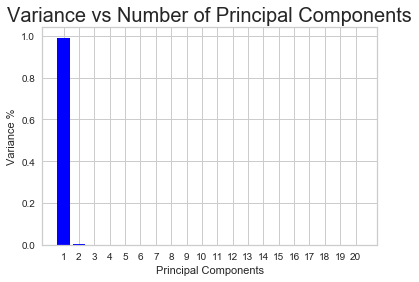

In [28]:
pc_range = range(1, pca.n_components_+1)
plt.title("Variance vs Number of Principal Components", size=20)
plt.bar(pc_range, pca.explained_variance_ratio_, color='blue')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(pc_range)

Observation: From the chart, we can see a distinct drop-off after the second component. This means that the majority of the data can be explained by using only two principal components. 

In [29]:
pca = PCA(n_components=2)
X_df = pca.fit(cleaned_customers).transform(cleaned_customers)
pca.explained_variance_ratio_

array([0.99100201, 0.00206462])

### 2. K-Means Clustering 

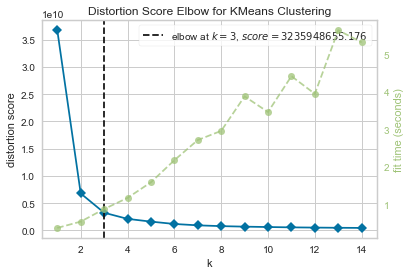

In [30]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15)) # Loop through model to find ideal number of clusters within the data

visualizer.fit(PCA_components)
visualizer.show()

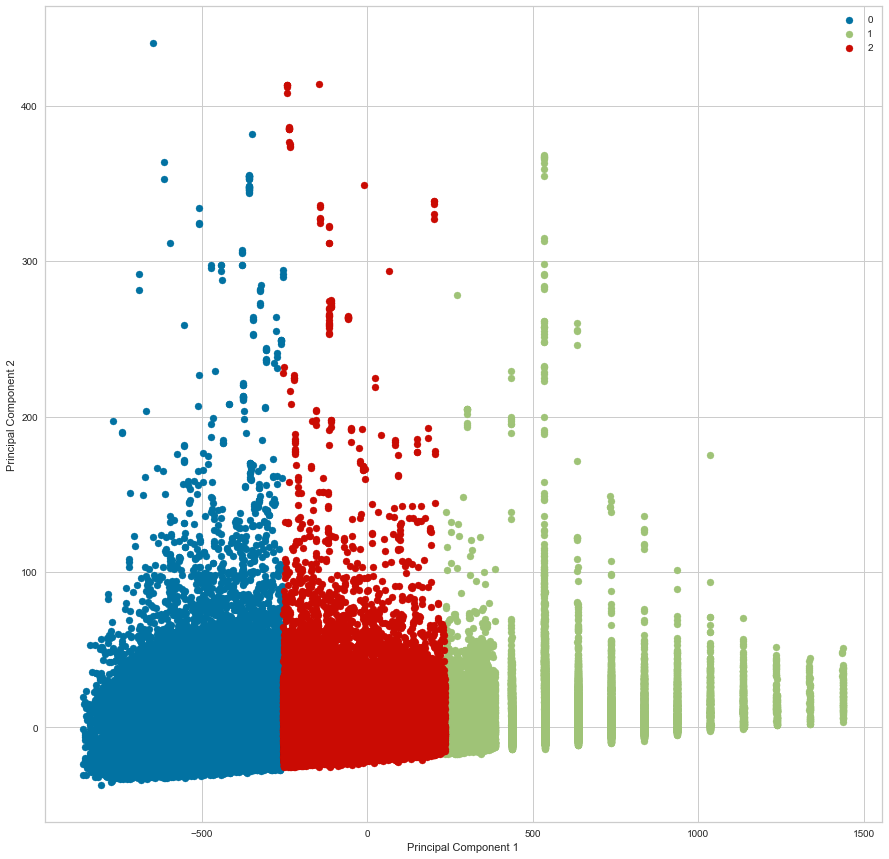

In [31]:
k_means_model = KMeans(n_clusters = 3, init = "k-means++")
k_means_pred = k_means_model.fit_predict(X_df) # Fitting the data onto the K-means clustering algorithm
uniq = np.unique(k_means_pred)
plt.figure(figsize=(15,15))
for i in uniq:
  plt.scatter(X_df[k_means_pred == i , 0] , X_df[k_means_pred == i , 1] , label = i)

plt.xlabel([])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show() # Plotting the data onto a chart

In [32]:
cleaned_customers['cluster'] = k_means_model.labels_ # Adding extra column to the Customers dataframe to allocate data to separate groups
cleaned_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.0,1.0,10.0,10.0,1.0,1.0,1.0,2.0,1.0,1.0,...,6.0,9.0,7.0,3,1,0,1.0,1,4,1
9628,2.0,9.0,11.0,10.0,1.0,1.0,1.0,3.0,1.0,1.0,...,6.0,9.0,3.0,3,2,1,1.0,1,4,1
143872,2.0,1.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.0,9.0,2.0,3,1,0,1.0,2,4,0
143873,1.0,1.0,8.0,8.0,1.0,1.0,1.0,2.0,1.0,1.0,...,6.0,9.0,7.0,1,0,0,1.0,1,4,2
143874,2.0,1.0,20.0,14.0,7.0,1.0,1.0,4.0,7.0,1.0,...,2.0,9.0,3.0,1,2,0,1.0,1,3,0


In [33]:
# Locating the central locations of the clusters
array = k_means_model.cluster_centers_
array = array.astype(int)
array

array([[-441,    0],
       [ 534,    0],
       [ -64,    1]])

In [34]:
# Allocating the clustered groups onto different dataframes
dataframe_cluster_0 = cleaned_customers[cleaned_customers['cluster'] == 0]
dataframe_cluster_1 = cleaned_customers[cleaned_customers['cluster'] == 1]
dataframe_cluster_2 = cleaned_customers[cleaned_customers['cluster'] == 2]

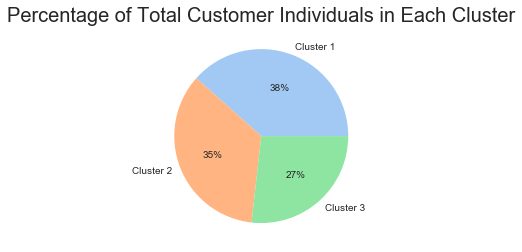

In [35]:
#define data
data = [len(dataframe_cluster_0), len(dataframe_cluster_1), len(dataframe_cluster_2)]
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title('Percentage of Total Customer Individuals in Each Cluster', size = 20)
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()


### Modelling of General Population

In [36]:
pca = PCA(n_components=2)
pop_X_df = pca.fit(cleaned_population).transform(cleaned_population)
PCA_components = pd.DataFrame(pop_X_df)
print("The 2 principal components are able to explain {:.2f}% of the data.".format(sum(pca.explained_variance_ratio_) * 100))

The 2 principal components are able to explain 99.05% of the data.


In [37]:
k_means_pred = k_means_model.fit_predict(cleaned_population)

In [38]:
cleaned_population['cluster'] = k_means_model.labels_ # Adding extra column to the Customers dataframe to allocate data to separate groups
cleaned_population.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
LNR,,,,,,,,,,,,,,,,,,,,,
910215,2.0,1.0,18.0,15.0,1.0,1.0,1.0,1.0,1.0,1.0,...,10.0,10.0,10.0,6.0,9.0,3.0,3,1,2,1
910220,2.0,9.0,18.0,21.0,11.0,1.0,1.0,2.0,12.0,1.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,0
910225,2.0,9.0,17.0,17.0,10.0,1.0,1.0,1.0,7.0,1.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,0
910226,2.0,1.0,13.0,13.0,1.0,1.0,1.0,1.0,2.0,1.0,...,7.0,10.0,11.0,6.0,9.0,7.0,3,2,4,0
910241,2.0,1.0,20.0,14.0,3.0,1.0,1.0,4.0,3.0,1.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,2


In [39]:
# Allocating the clustered groups onto different dataframes
pop_dataframe_cluster_0 = cleaned_population[cleaned_population['cluster'] == 0]
pop_dataframe_cluster_1 = cleaned_population[cleaned_population['cluster'] == 1]
pop_dataframe_cluster_2 = cleaned_population[cleaned_population['cluster'] == 2]

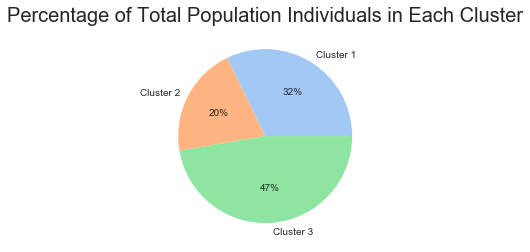

In [40]:
#define data
data = [len(pop_dataframe_cluster_0), len(pop_dataframe_cluster_1), len(pop_dataframe_cluster_2)]
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title('Percentage of Total Population Individuals in Each Cluster', size = 20)
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

### Feature Importance in Cluster allocation
- After finding our clusters, it is important to identify the most influential features from the original dataframe. This will tells us which features will yield important information on our customers.

In [41]:
rfc_df = cleaned_customers.copy()
rfc_y = rfc_df.pop('cluster')
rfc_X = rfc_df[:]
rfc_X.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.0,1.0,10.0,10.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,6.0,9.0,7.0,3,1,0,1.0,1,4
9628,2.0,9.0,11.0,10.0,1.0,1.0,1.0,3.0,1.0,1.0,...,3.0,6.0,9.0,3.0,3,2,1,1.0,1,4
143872,2.0,1.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,1,0,1.0,2,4
143873,1.0,1.0,8.0,8.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,6.0,9.0,7.0,1,0,0,1.0,1,4
143874,2.0,1.0,20.0,14.0,7.0,1.0,1.0,4.0,7.0,1.0,...,4.0,2.0,9.0,3.0,1,2,0,1.0,1,3


In [42]:
rfc_y.head()

LNR
9626      1
9628      1
143872    0
143873    2
143874    0
Name: cluster, dtype: int32

In [43]:
rfc_X_train, rfc_X_test, rfc_y_train, rfc_y_test = train_test_split(rfc_X, rfc_y) # Splitting the data into training and testing datasets

In [44]:
rfc = RandomForestClassifier()
rfc.fit(rfc_X_train, rfc_y_train)
rfc_pred = rfc.predict(rfc_X_test)

In [45]:
print ("Accuracy : {:.2f}%".format(accuracy_score(rfc_y_test, rfc_pred)*100))

Accuracy : 99.91%


In [46]:
rfc_array = rfc.feature_importances_

In [47]:
#df = pd.DataFrame(array.reshape(1, 368), columns=X.columns)
# Arranging the most important features into a list
rfc_importances = []
count = 0
for i in rfc_array:
    rfc_importances.append([i, rfc_X.columns[count]])
    count += 1

In [48]:
# Sorting the feature importances from maximum importance to least.
rfc_importances.sort(reverse=True)
rfc_labels = []
rfc_values = []
for i in rfc_importances[0:20]:
    rfc_labels.append(i[1])
    rfc_values.append(i[0])

rfc_importances[0:20]

[[0.24217735934215232, 'KBA13_ANZAHL_PKW'],
 [0.05005485672135503, 'KBA13_HHZ'],
 [0.04572290426937106, 'PLZ8_HHZ'],
 [0.03740213049056531, 'KBA13_GBZ'],
 [0.027636666564077636, 'D19_KONSUMTYP_MAX'],
 [0.02354778118223491, 'SEMIO_VERT'],
 [0.02146813771750337, 'PLZ8_GBZ'],
 [0.021072252473947357, 'KOMBIALTER'],
 [0.020778330346802407, 'SEMIO_REL'],
 [0.015138280091952424, 'FINANZ_ANLEGER'],
 [0.014625490477697057, 'SEMIO_SOZ'],
 [0.013473901682897676, 'SEMIO_KRIT'],
 [0.013242095305327524, 'FINANZ_SPARER'],
 [0.013190333990400756, 'CJT_TYP_2'],
 [0.010550101736868035, 'KBA13_KMH_0_140'],
 [0.010356271903265274, 'SEMIO_DOM'],
 [0.010239887404236397, 'KBA13_AUTOQUOTE'],
 [0.010004163786583484, 'SEMIO_FAM'],
 [0.009354620325972904, 'KBA13_KMH_140'],
 [0.0086633889660564, 'CJT_GESAMTTYP']]

C:\Users\Daniel\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Feature Importances in Cluster Allocation')

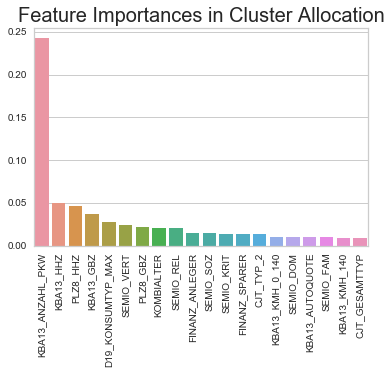

In [49]:
sns.barplot(rfc_labels, rfc_values)
plt.xticks(rotation=90)
plt.title('Feature Importances in Cluster Allocation', size = 20)

Important: The biggest factor seems to the number of cars in the postal code area. This could indicate the type of financial product Arvato is selling.

## Exploratory Data Analysis
- Here we will be looking at some characteristics of the customers population, as well as the most important features in the dataset. 
- Due to the nature of the dataset, we will refer to the "DIAS Attributes - Values 2017" csv file to understand the meaning of the categorical values. 

C:\Users\Daniel\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


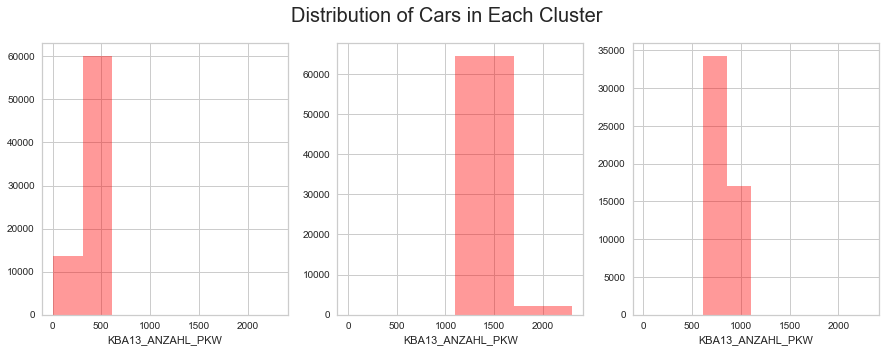

In [109]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Distribution of Cars in Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA13_ANZAHL_PKW'],  ax=axes[0], color ='red', bins = 2, kde = False)
sns.distplot(dataframe_cluster_1['KBA13_ANZAHL_PKW'],  ax=axes[1], color ='red', bins = 2, kde = False)
sns.distplot(dataframe_cluster_2['KBA13_ANZAHL_PKW'],  ax=axes[2], color ='red', bins = 2, kde = False)

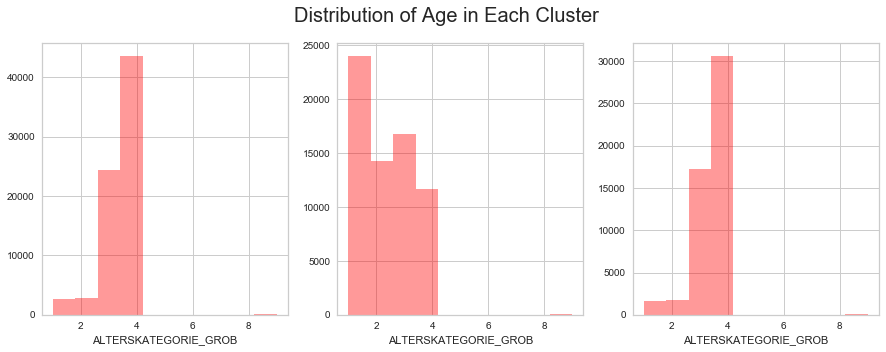

In [52]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Distribution of Age in Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['ALTERSKATEGORIE_GROB'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['ALTERSKATEGORIE_GROB'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['ALTERSKATEGORIE_GROB'],  ax=axes[2], color ='red', bins = 10, kde = False)

### Oberservations:
- The first cluster has a younger population with individuals falling into the category of less than 30 years of age, and between the ages of 30 and 45. 
- The second cluster tends to have a larger population of middle aged individuals ranging from 46 - 60 years of age. 
- The third cluster has the largest percentage of individuals who are over the age of 60 years of age

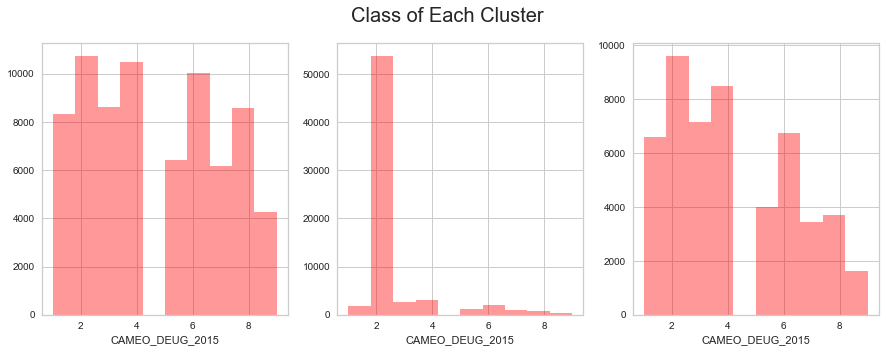

In [58]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Class of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['CAMEO_DEUG_2015'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['CAMEO_DEUG_2015'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['CAMEO_DEUG_2015'],  ax=axes[2], color ='red', bins = 10, kde = False)

In [59]:
dataframe_cluster_1['CAMEO_DEUG_2015'].unique()

array([1., 2., 5., 3., 4., 6., 7., 8., 9.])

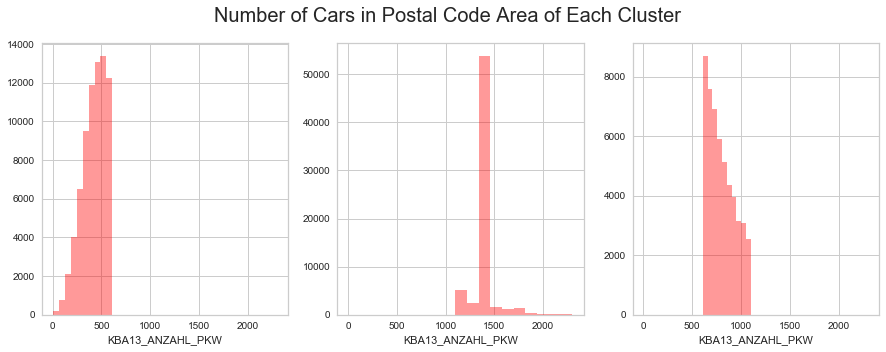

In [60]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Number of Cars in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA13_ANZAHL_PKW'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['KBA13_ANZAHL_PKW'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['KBA13_ANZAHL_PKW'],  ax=axes[2], color ='red', bins = 10, kde = False)

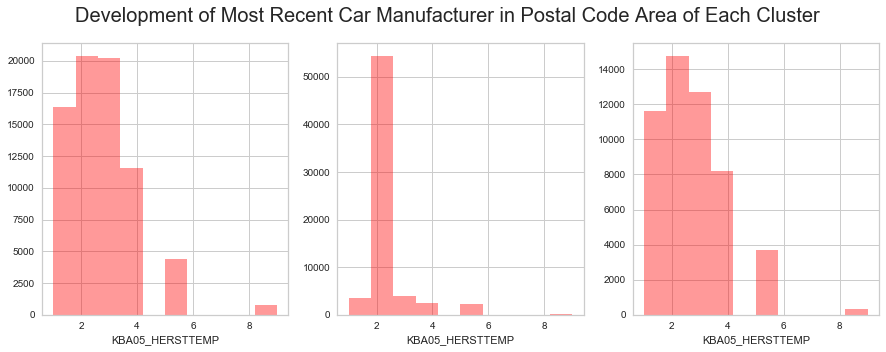

In [63]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Development of Most Recent Car Manufacturer in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA05_HERSTTEMP'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['KBA05_HERSTTEMP'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['KBA05_HERSTTEMP'],  ax=axes[2], color ='red', bins = 10, kde = False)

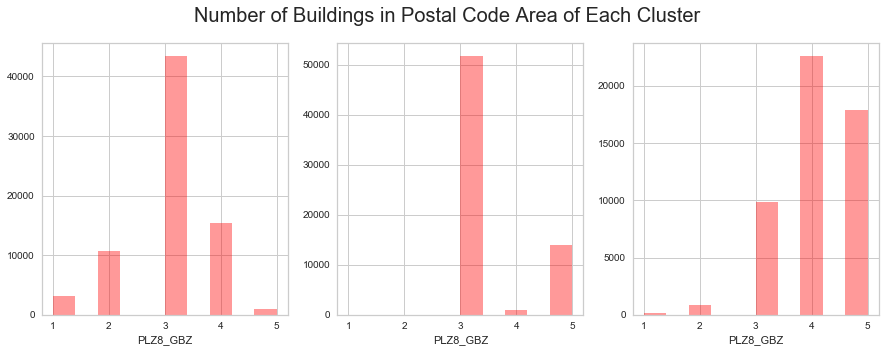

In [64]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Number of Buildings in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['PLZ8_GBZ'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['PLZ8_GBZ'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['PLZ8_GBZ'],  ax=axes[2], color ='red', bins = 10, kde = False)

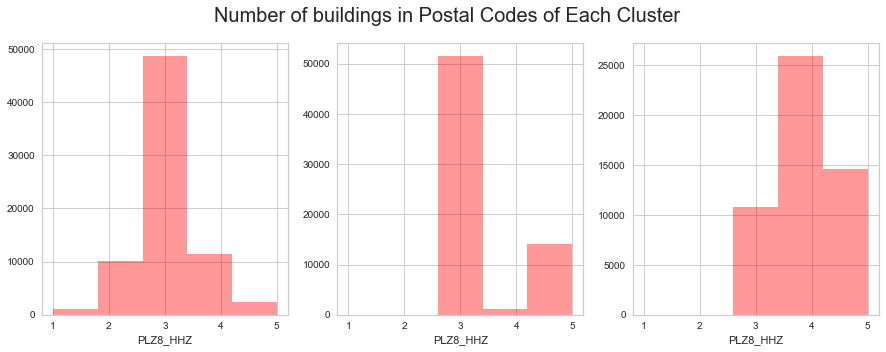

In [110]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Number of buildings in Postal Codes of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['PLZ8_HHZ'],  ax=axes[0], color ='red', bins = 5, kde = False)
sns.distplot(dataframe_cluster_1['PLZ8_HHZ'],  ax=axes[1], color ='red', bins = 5, kde = False)
sns.distplot(dataframe_cluster_2['PLZ8_HHZ'],  ax=axes[2], color ='red', bins = 5, kde = False)

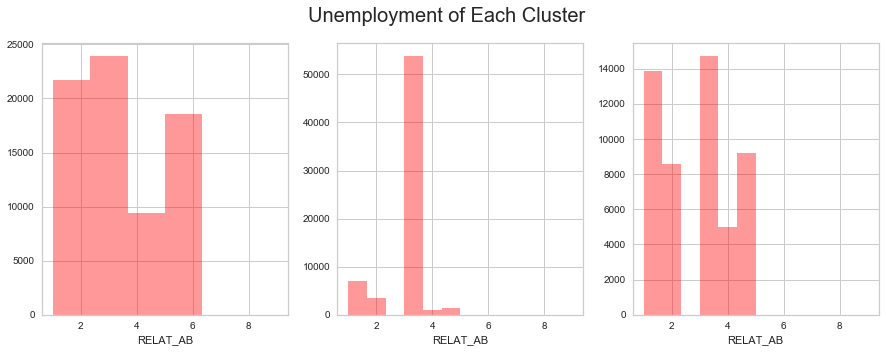

In [67]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Unemployment of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['RELAT_AB'],  ax=axes[0], color ='red', bins = 6, kde = False)
sns.distplot(dataframe_cluster_1['RELAT_AB'],  ax=axes[1], color ='red', bins = 6, kde = False)
sns.distplot(dataframe_cluster_2['RELAT_AB'],  ax=axes[2], color ='red', bins = 6, kde = False)

In [70]:
filtered_customers = cleaned_customers.filter(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 
                                       'D19_BANKEN_ANZ_24',
                          'D19_BANKEN_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM',
                           'D19_VERSAND_ONLINE_QUOTE_12', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
                          'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR',
                          'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
                          'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                          'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
                          'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
                           'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
                          'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 
                           'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
                           'ONLINE_AFFINITAET', 'REGIOTYP'])

for i in filtered_customers:
        filtered_customers[i] = filtered_customers[i].astype(int)

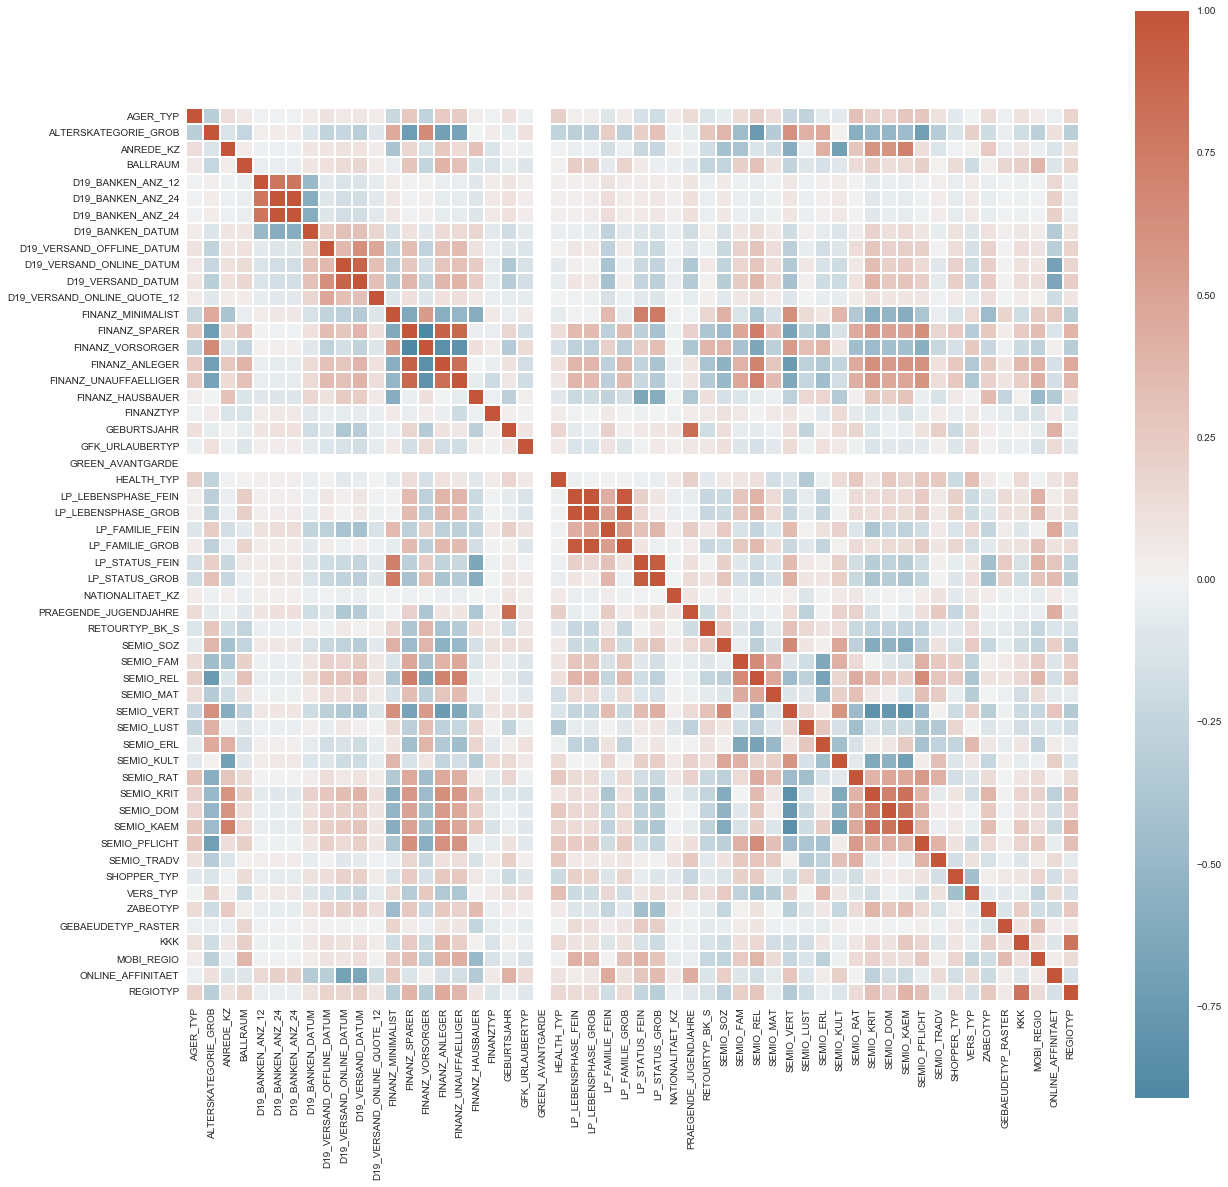

In [71]:
#sns.set_theme(style="white")

# Obtaining correlation matrix
#corr_df = filtered_customers.copy() #.drop(['cluster'], axis=1)
corr = filtered_customers.corr()

# Matplotlib graph setup 
f, ax = plt.subplots(figsize=(20, 20))

# Generating Seaplot colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 1}, fmt=".2f")

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [72]:
train_csv = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
train_csv.head()

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [73]:
train_csv.drop_duplicates(keep = 'first', inplace = True)

In [74]:
def second_preprocessing (dataframe):
    """Cleaning of dataframe for better data processing. """
    dataframe = dataframe.copy()
    dataframe = dataframe.set_index(['LNR']) # Set the Customer ID to index of dataframe

    #dataframe.drop_duplicates(keep = 'first', inplace = True) # Removes any duplicates from the 
    dataframe.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM'], axis=1, inplace=True) # Drops LNR which is the customer id 
    
    dataframe.replace(-1, float('NaN'), inplace=True) # -1 values represent missing values, and will be replaced with NaN values
    dataframe.replace(0, float('NaN'), inplace=True) # 0 values represent unknown values, and will be replaced with NaN values
    
    dataframe['CAMEO_DEU_2015'].replace('XX', dataframe['CAMEO_DEU_2015'].mode().iloc[0], inplace=True) # Replace unknown string to mode value
    
    dataframe['CAMEO_DEUG_2015'].replace('X', dataframe['CAMEO_DEUG_2015'].mode().iloc[0], inplace=True)
    dataframe['CAMEO_DEUG_2015'] = dataframe['CAMEO_DEUG_2015'].apply(pd.to_numeric) # Convert to integer values
    
    dataframe['CAMEO_INTL_2015'].replace('XX', dataframe['CAMEO_INTL_2015'].mode().iloc[0], inplace=True)
    dataframe['CAMEO_INTL_2015'] = dataframe['CAMEO_INTL_2015'].apply(pd.to_numeric) # Convert to integer values
    
    new_list = []
            
    for i in dataframe:
        dataframe[i] = dataframe[i].fillna(dataframe[i].mode().iloc[0]) # Mode is used to replace NaN values due to categorical values
    
    dataframe = pd.get_dummies(dataframe)
    
    """for i in range(0, dataframe.shape[1]):     
        if (dataframe.iloc[:, i].dtypes == 'object'): # All object dtypes to be converted to categorical values
            dataframe.iloc[:, i] = pd.Categorical(dataframe.iloc[:, i])
            dataframe.iloc[:, i] = dataframe.iloc[:, i].cat.codes 
            dataframe.iloc[:, i] = dataframe.iloc[:, i].astype('int64')
            new_list.append(dataframe.columns[i])"""
    
    
    return dataframe # return cleaned dataframe

In [75]:
# Function for viewing the number of positive responses
def response_counter(response_array):
    """Counts the number of positive and negative responses in purchasing. """
    number_of_yes = 0 
    number_of_no = 0
    for i in response_array:
        if i == 1:
            number_of_yes += 1
        else:
            number_of_no += 1
    return number_of_yes, number_of_no

In [76]:
# Obtaining obtaining target features 
y = train_csv.pop('RESPONSE') # Pop off target fature 
X = train_csv[:] # Store features in separate variable for processing
X.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3


In [77]:
X = second_preprocessing(X)
X.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
1763,2.0,1.0,8.0,8.0,15.0,1.0,1.0,1.0,13.0,1.0,...,0,0,0,1,0,0,0,0,0,1
1771,1.0,4.0,13.0,13.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,1
1776,1.0,1.0,9.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1460,2.0,1.0,6.0,6.0,4.0,1.0,1.0,2.0,4.0,1.0,...,0,0,0,1,0,0,0,0,0,1
1783,2.0,1.0,9.0,9.0,53.0,1.0,1.0,1.0,44.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [78]:
# Viewing number of target feature rows
print(y.unique())
# Number of unique values in target feature
print(y.nunique())

[0 1]
2


In [79]:
number_of_yes, number_of_no = response_counter(y)
print("The number of yes responses in target column is {}, and the number of no responses is {}".format(number_of_yes, number_of_no))

The number of yes responses in target column is 532, and the number of no responses is 42430


### Modelling of Supervised Learning Model 
- The goal is to:
    - Normalize the features
    - Create training, testing and validation datasets
    - Train the model using a Random Forest Classifier or XGBoost Model 
    - Evaluate the model

In [80]:
sc = StandardScaler()
scaled_X = sc.fit_transform(X)

In [81]:
response_counter(y)

(532, 42430)

In [82]:
# Split data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=2, stratify=y)

### XGBoost

In [83]:
xgboost_model = xgb.XGBClassifier(colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, n_estimators=10, subsample=0.8, e_label_encoder=False)

param_grid = {
    'n_estimators': [10, 100, 200],
    min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

xgboost_model = GridSearchCV(model, param_grid, scoring='roc_auc', verbose=3)
xgboost_model.fit(X_train, y_train)

C:\Users\Daniel\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "e_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, e_label_encoder=False,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=6, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [84]:
xgb_pred = xgboost_model.predict(X_test)

The best parameters for the XGBoost Grid Search was:
    - (colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, n_estimators=10, subsample=0.8)

In [85]:
# Assessing the accuracy of the XGBoost 
from sklearn.metrics import accuracy_score
xgb_pred = xgboost_model.predict(X_test)
print ("Accuracy : {:.2f}%".format(accuracy_score(y_test, xgb_pred)*100))

Accuracy : 98.77%


In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8487
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, xgb_pred)

0.5

In [88]:
import pickle
filename = 'XGBoost.pkl'
pickle.dump(xgboost_model, open(filename, 'wb'))

## Random Forest Classifier

In [89]:
rfc = RandomForestClassifier(random_state = 42)
    
parameters = {
            'n_estimators': [200, 500],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
            }
    
cv = GridSearchCV(rfc, param_grid=parameters, verbose = 3, scoring='roc_auc')
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

The best parameters for the Random Forest Classifier was:
    - ('n_estimators': [200], 'max_features': ['auto'], 'max_depth' : [4], 'criterion' :['gini'])

In [90]:
rfc_pred = rfc.predict(X_test)

In [91]:
print ("Accuracy : {:.2f}%".format(accuracy_score(y_test, rfc_pred)*100))

Accuracy : 98.77%


In [92]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8487
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
print(roc_auc_score(y_test, rfc_pred))

0.5


In [94]:
rfc_pred = rfc.predict(X_test)
print ("Accuracy : {:.2f}%".format(accuracy_score(y_test, rfc_pred)*100))
print(classification_report(y_test, rfc_pred))

Accuracy : 98.77%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8487
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
filename = 'RandomForestClassifier.pkl'
pickle.dump(rfc, open(filename, 'wb'))

## Test Dataset

In [96]:
test_csv = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
test_csv.head()

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [97]:
X = test_csv[:]

In [98]:
X = second_preprocessing(test_csv)

In [99]:
scaled_X = sc.fit_transform(X)

In [100]:
r_pred = rfc.predict_proba(scaled_X)
xgb_pred = xgboost_model.predict_proba(scaled_X)

In [101]:
pred_csv = pd.DataFrame()

In [102]:
pred_csv['LNR'] = test_csv['LNR']

In [103]:
pred_csv.head()

,LNR
0,1754
1,1770
2,1465
3,1470
4,1478


In [104]:
# Ensemble technique to improve accuracy of predictions on test dataset
pred_csv['rfc_response'] = r_pred[:, 1]
pred_csv['xgb_response'] = xgb_pred[:, 1]
pred_csv['RESPONSE'] = (pred_csv['rfc_response']+ pred_csv['xgb_response'])/2 # Return the average probablity between the models

In [105]:
pred_csv.head()

,LNR,rfc_response,xgb_response,RESPONSE
0,1754,0.01,0.048992,0.019664
1,1770,0.00,0.042060,0.014020
2,1465,0.01,0.026738,0.012246
3,1470,0.01,0.026948,0.012316
4,1478,0.03,0.035771,0.021924


In [106]:
pred_csv.drop(['rfc_response', 'xgb_response'], axis=1, inplace=True)

In [107]:
pred_csv.head()

,LNR,RESPONSE
0,1754,0.019664
1,1770,0.014020
2,1465,0.012246
3,1470,0.012316
4,1478,0.021924


In [108]:
pred_csv.to_csv("Arvato_Test_prediction.csv", index=False)

### - Overall Score of 0.75

# Conclusion: 

From the data we can conclude that there are actually two main groups of people in the customer population. There are three clusters but the first and third clusters are relatively similar. The main difference is that the third cluster has areas with higher building density and lower unemployment. 

The second cluster, however, is made up of a generally younger population from a mostly upper middle class status. They tend to originate from area codes where there are more cars owned as compared to the other clusters. They also tend to have a higher rate of unemployment. The other group tends to be older and have a more even distribution of income classes.  In the general population, the majority of individuals tend to be older and have greater rates of employment. 

The supervised learning model scored roughly 75% of the dataset on Kaggle. This is a relatively average performing model as the Customer dataset contains a lot of noise. Noise is likely unnecessary information that makes it difficult for the model to make accurate predictions. The highest score was 86% and therefore the results are not far off. The model performed averagely and would like not be able to accurately identify which clusters are more likely to purchase products - even the highest performing model will likely underperform. 